<a href="https://colab.research.google.com/github/mjsmagalhaes/examples-datascience/blob/main/restaurant_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Restaurant Review Analysis

## Setup




Initial tasks to prepare the data

### Importing Libraries

In [ ]:
import graphviz as graph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz, export_text
from sklearn.neural_network import MLPClassifier, MLPRegressor

from tensorflow.keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense

from lib.analysis import Analysis

### Loading Dataset

In [ ]:
a = Analysis.from_csv('data/Restaurant_Reviews.csv')
corpus = a.columns('Review').to_list()

## Extracting

In [ ]:
# Create Train x Test Sets
# xTrain, xTest, yTrain, yTest = train_test_split(x,y, test_size=0.2, random_state=0)

vocabs = a.nlp.extract_vocab(corpus)

# "Clear" Corpus Using Vocabulary
extracted_corpus = a.nlp.extract_corpus(corpus, vocabs)

# Extract Corpus
x = a.nlp.vectorize(extracted_corpus, vocabs)
y = a.columns(['Liked'])

## Building Model

In [ ]:
xTrain, xTest, yTrain, yTest = train_test_split(x,y, test_size=0.2, random_state=0)
n_dim = len(vocabs)

# Neural Network Model
model = Sequential([
    Dense(units=700,activation='relu',input_shape=(n_dim,)),
    Dense(units=1,activation='relu')
])

model.compile(
    optimizer=SGD(momentum=0.2,learning_rate=0.2),
    loss="mean_squared_error"
)

# model = MLPRegressor(
#         solver='sgd',
#         activation='relu',
#         hidden_layer_sizes=(700,),
#         # learning_rate='invscaling',
#         learning_rate_init=0.1,
#         momentum=0.2,
#         # power_t=0.1,
#         max_iter=1000,
#         # early_stopping = True,
#         random_state = 1001
#     )

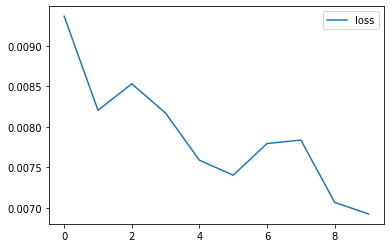

In [ ]:
th = model.fit(
    xTrain, 
    yTrain.values.ravel(),
    epochs=10,
    # steps_per_epoch=1,
    # validation_split=None, 
    verbose=0
)

pd.DataFrame(th.history.get('loss'), columns=['loss']).plot.line()
y_pred = model.predict(xTest).reshape(-1,1)

In [ ]:
tree = DecisionTreeClassifier(max_depth=5).fit(y_pred, yTest)
y_pred_tree = tree.predict(y_pred)

# Neural Networking "Post-Processing"
y_pred_cat = list(map(lambda y: 0 if y < 0.468 else 1, y_pred)) # y_pred.round()

## Evaluating Models

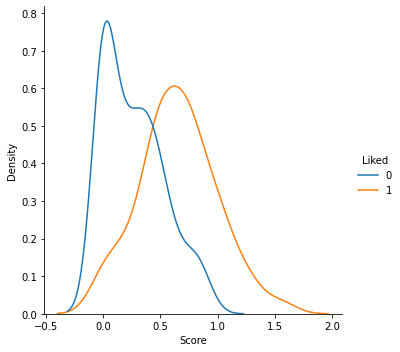

In [ ]:
y = pd.DataFrame(y_pred, columns=['Score'])
y = y.join(yTest.reset_index())

sns.displot(y, x='Score', hue='Liked', kind='kde')

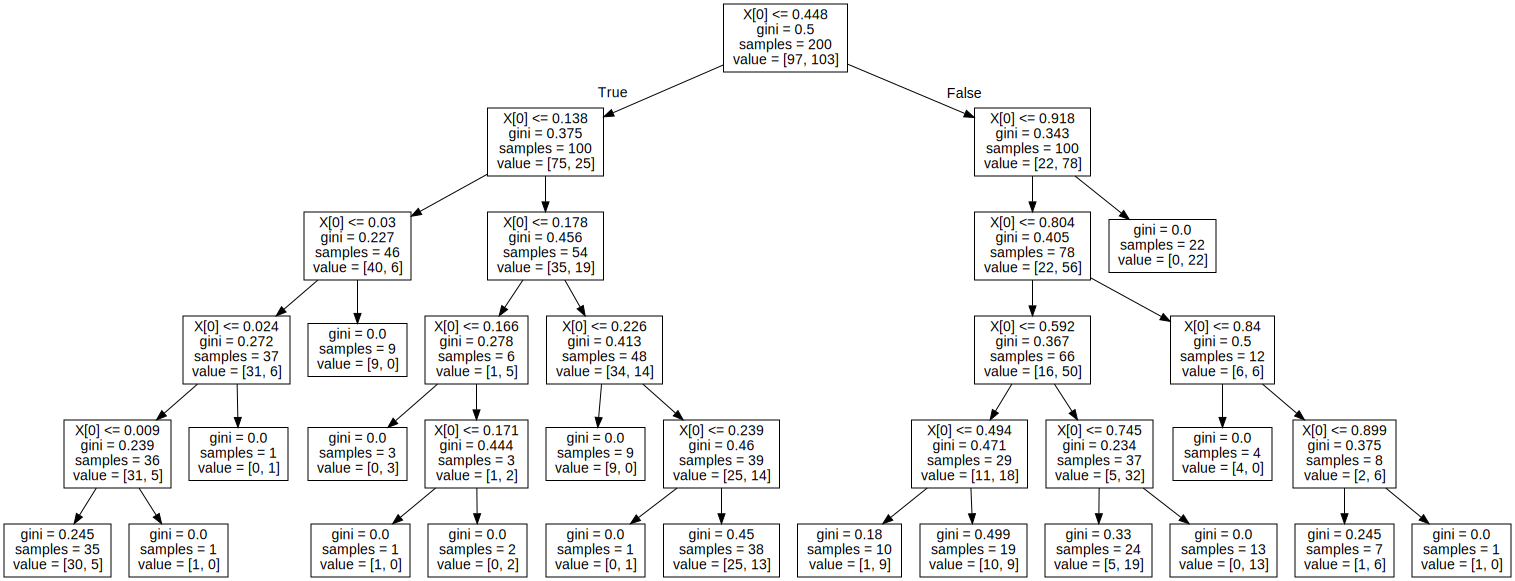

In [ ]:
# Save Tree
g = graph.Source(export_graphviz(tree))
g
# g.render(filename='tree')

In [ ]:
a.evaluate(yTest, y_pred_cat)
a.evaluate(yTest, y_pred_tree)